# Aircraft Audio - Classification Model (Crepe + STFT)
#### Binary Classifier 
Last Updated November 26, 2019

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import pywt
from matplotlib.image import imread
import numpy as np
import os
from scipy.io import wavfile
from pathlib import Path
import pywt
import soundfile
import random
import pickle
from glob import iglob
import crepe
from sklearn.metrics import confusion_matrix, classification_report
import pprint
random.seed(42)
import librosa
import scipy.signal
from scipy.signal import resample
from tensorflow.keras.layers import MaxPooling2D, Flatten, Conv2D
from keras.utils import to_categorical
import keras, tensorflow
from keras.layers import initializers 
from keras.layers import regularizers 
from keras.layers import constraints 
from keras.layers import Activation
from keras.layers.advanced_activations import PReLU
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.advanced_activations import ELU
from keras.constraints import max_norm
from keras.layers import LeakyReLU
from tensorflow.keras import optimizers, losses, activations, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.layers import Dense, Input, Dropout, Convolution1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, \
    concatenate
from tensorflow.keras.layers import MaxPooling3D, Flatten, Conv3D
from keras import backend as K
from tensorflow.keras.layers import LeakyReLU,PReLU
#import keras
from keras.losses import *
def my_init(shape,  dtype=None):
    vals=((float(shape[0], float(shape[1]))) * math.sqrt(2./float(shape[1])))
    return K.random_normal(vals, dtype=dtype)    
import math
from pydub import AudioSegment
from pydub.playback import play
import specAugment
# from specAugment import spec_augment_tensorflow

Using TensorFlow backend.


In [2]:
# Change working directory to local lcoation for this file.
os.chdir('/home/niwilso/neurips/Industrial-Audio-Classification/Data/Aircraft-Audio/')
base_dir = '/home/niwilso/neurips/Industrial-Audio-Classification/Data/Aircraft-Audio/'
WorkingDir = os.path.join(base_dir)
print(os.getcwd())

# Check files at this folder location
import glob
filelist = glob.glob("*.txt")
print(filelist)

/home/niwilso/neurips/Industrial-Audio-Classification/Data/Aircraft-Audio
['Bombardier_slices_test_matrix.txt', 'Airbus_slices_train_matrix.txt', 'foo.txt', 'Airbus_slices_test_matrix.txt', 'Embraer_slices_train_matrix.txt', 'Embraer_slices_test_matrix.txt', 'Boeing_slices_test_matrix.txt', 'Bombardier_slices_train_matrix.txt', 'Boeing_slices_train_matrix.txt']


In [3]:
filelist[0]

'Bombardier_slices_test_matrix.txt'

### Load and Inspect Data

In [4]:
# Original audio recordings have already been split to samples of 1 second 32000 at sample rate and stored in numpy array.
print(os.getcwd())

Train_matrix_airbus = np.loadtxt('Airbus_slices_train_matrix.txt', delimiter=',')
Test_matrix_airbus = np.loadtxt('Airbus_slices_test_matrix.txt', delimiter=',')
Train_matrix_boeing = np.loadtxt('Boeing_slices_train_matrix.txt', delimiter=',')
Test_matrix_boeing = np.loadtxt('Boeing_slices_test_matrix.txt', delimiter=',')
Train_matrix_bombardier = np.loadtxt('Bombardier_slices_train_matrix.txt', delimiter=',')
Test_matrix_bombardier = np.loadtxt('Bombardier_slices_test_matrix.txt', delimiter=',')
Train_matrix_embraer = np.loadtxt('Embraer_slices_train_matrix.txt', delimiter=',')
Test_matrix_embraer = np.loadtxt('Embraer_slices_test_matrix.txt', delimiter=',')


/home/niwilso/neurips/Industrial-Audio-Classification/Data/Aircraft-Audio


In [5]:
import librosa.display
import matplotlib.pyplot as plt

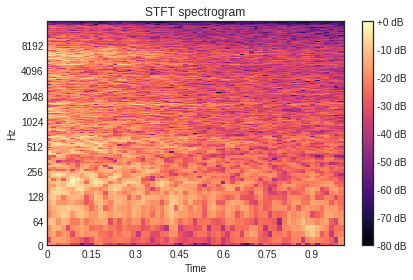

In [6]:
# Visualize plain STFT
C = np.abs(librosa.stft(Train_matrix_airbus[20,:]))
librosa.display.specshow(librosa.amplitude_to_db(C, ref=np.max),
                         sr=32000, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('STFT spectrogram')
plt.tight_layout()

In [7]:
np.shape(C)

(1025, 63)

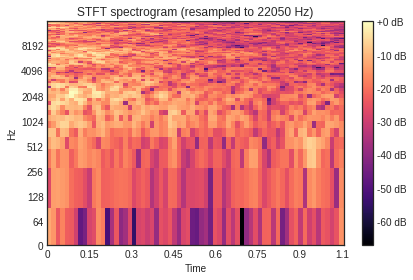

In [8]:
# Downsample to lower resolution
tmp = np.asfortranarray(resample(Train_matrix_airbus[20,:], 22050//8))
C = np.abs(librosa.stft(y=tmp, n_fft=2048//12))
librosa.display.specshow(librosa.amplitude_to_db(C, ref=np.max),
                         sr=32000, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('STFT spectrogram (resampled to 22050 Hz)')
plt.tight_layout()

In [9]:
np.shape(C)

(86, 66)

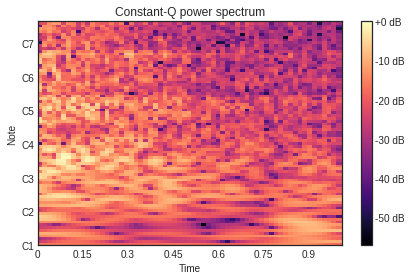

In [10]:
# Compare visually with CQT (just checking)
C = np.abs(librosa.cqt(Train_matrix_airbus[20,:], sr=32000, fmin=librosa.note_to_hz('C1'), n_bins=80, bins_per_octave=12))
librosa.display.specshow(librosa.amplitude_to_db(C, ref=np.max),
                         sr=32000, x_axis='time', y_axis='cqt_note')
plt.colorbar(format='%+2.0f dB')
plt.title('Constant-Q power spectrum')
plt.tight_layout()

In [11]:
np.shape(C)

(80, 63)

[10312.  4069.  -260. ...   -23.  -277.     0.]


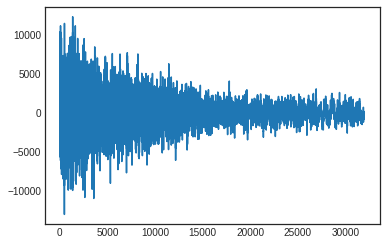

In [12]:
signal = Train_matrix_airbus[20,:]
time = 32000
print(signal)
plt.plot(signal)
plt.show()

### Add Augmented Data

In [13]:
def _create_augmented_volume_reduction_data_matrix(old_matrix, volume_change):
    
    old_matrix = np.asarray(old_matrix)
    new_target_numpy = np.empty((32000),int)
    new_target_numpy = np.asarray(new_target_numpy)    

    for i in range(old_matrix.shape[0]):
        new_numpy = old_matrix[i,:] + volume_change
        new_numpy = np.asarray(new_numpy)
        new_target_numpy = np.vstack((new_target_numpy, new_numpy))
        new_target_numpy = np.asarray(new_target_numpy)
    return(new_target_numpy)

In [14]:
# Create Augmented matrices with volume reduction
Augmented_Train_matrix_airbus = _create_augmented_volume_reduction_data_matrix(Train_matrix_airbus, -5)
Augmented_Test_matrix_airbus = _create_augmented_volume_reduction_data_matrix(Test_matrix_airbus, -5)

Augmented_Train_matrix_boeing = _create_augmented_volume_reduction_data_matrix(Train_matrix_boeing, -5)
Augmented_Test_matrix_boeing = _create_augmented_volume_reduction_data_matrix(Test_matrix_boeing, -5)

Augmented_Train_matrix_bombardier = _create_augmented_volume_reduction_data_matrix(Train_matrix_bombardier, -5)
Augmented_Test_matrix_bombardier = _create_augmented_volume_reduction_data_matrix(Test_matrix_bombardier, -5)

Augmented_Train_matrix_embraer = _create_augmented_volume_reduction_data_matrix(Train_matrix_embraer, -5)
Augmented_Test_matrix_embraer = _create_augmented_volume_reduction_data_matrix(Test_matrix_embraer, -5)

In [15]:
def _create_augmented_white_noise_data_matrix(old_matrix, noise_level):
    new_target_numpy = np.empty((32000),int)
    new_target_numpy = np.asarray(new_target_numpy)   
    
    for i in range(old_matrix.shape[0]):
        wn = np.random.randn(old_matrix.shape[1])
        new_numpy = old_matrix[i,:] + noise_level*wn
        new_numpy = np.asarray(new_numpy)
        new_target_numpy = np.vstack((new_target_numpy, new_numpy))
        new_target_numpy = np.asarray(new_target_numpy)
    return(new_target_numpy)
        

In [16]:
# Create Augmented matrices with white noise added
Augmented_Train_matrix_airbus_2= _create_augmented_white_noise_data_matrix(Train_matrix_airbus,0.01)
Augmented_Test_matrix_airbus_2 = _create_augmented_white_noise_data_matrix(Test_matrix_airbus,0.01)

Augmented_Train_matrix_boeing_2 = _create_augmented_white_noise_data_matrix(Train_matrix_boeing,0.01)
Augmented_Test_matrix_boeing_2 = _create_augmented_white_noise_data_matrix(Test_matrix_boeing,0.01)

Augmented_Train_matrix_bombardier_2= _create_augmented_white_noise_data_matrix(Train_matrix_bombardier,0.01)
Augmented_Test_matrix_bombardier_2 = _create_augmented_white_noise_data_matrix(Test_matrix_bombardier,0.01)

Augmented_Train_matrix_embraer_2 = _create_augmented_white_noise_data_matrix(Train_matrix_embraer,0.01)
Augmented_Test_matrix_embraer_2 = _create_augmented_white_noise_data_matrix(Test_matrix_embraer,0.01)

### Add Labels
Label as one vs other

In [17]:
# Add labels to source matrices

Train_matrix_airbus = np.c_[ np.ones(len(Train_matrix_airbus)),Train_matrix_airbus] 
Train_matrix_airbus[:, 0] =  1
print(Train_matrix_airbus.shape)

Test_matrix_airbus = np.c_[ np.ones(len(Test_matrix_airbus)),Test_matrix_airbus] 
Test_matrix_airbus[:, 0] =  1
print(Test_matrix_airbus.shape)

Train_matrix_boeing = np.c_[ np.ones(len(Train_matrix_boeing)),Train_matrix_boeing] 
Train_matrix_boeing[:, 0] =  1
print(Train_matrix_boeing.shape)

Test_matrix_boeing = np.c_[ np.ones(len(Test_matrix_boeing)),Test_matrix_boeing] 
Test_matrix_boeing[:, 0] =  1
print(Test_matrix_boeing.shape)

Train_matrix_bombardier = np.c_[ np.ones(len(Train_matrix_bombardier)),Train_matrix_bombardier] 
Train_matrix_bombardier[:, 0] =  1
print(Train_matrix_bombardier.shape)

Test_matrix_bombardier = np.c_[ np.ones(len(Test_matrix_bombardier)),Test_matrix_bombardier] 
Test_matrix_bombardier[:, 0] =  1
print(Test_matrix_bombardier.shape)

Train_matrix_embraer = np.c_[ np.ones(len(Train_matrix_embraer)),Train_matrix_embraer] 
Train_matrix_embraer[:, 0] =  0
print(Train_matrix_embraer.shape)

Test_matrix_embraer = np.c_[ np.ones(len(Test_matrix_embraer)),Test_matrix_embraer] 
Test_matrix_embraer[:, 0] =  0
print(Test_matrix_embraer.shape)

(37, 32001)
(19, 32001)
(67, 32001)
(50, 32001)
(39, 32001)
(24, 32001)
(34, 32001)
(23, 32001)


In [18]:
#Add labels to augmented Matrices
# Volume reduction
Augmented_Train_matrix_airbus = np.c_[ np.ones(len(Augmented_Train_matrix_airbus)),Augmented_Train_matrix_airbus] 
Augmented_Train_matrix_airbus[:, 0] = 1
Augmented_Train_matrix_airbus = np.delete(Augmented_Train_matrix_airbus, (0), axis=0)
print(Augmented_Train_matrix_airbus.shape)

Augmented_Test_matrix_airbus = np.c_[ np.ones(len(Augmented_Test_matrix_airbus)),Augmented_Test_matrix_airbus] 
Augmented_Test_matrix_airbus[:, 0] = 1
Augmented_Test_matrix_airbus = np.delete(Augmented_Test_matrix_airbus, (0), axis=0)
print(Augmented_Test_matrix_airbus.shape)

Augmented_Train_matrix_boeing = np.c_[ np.ones(len(Augmented_Train_matrix_boeing)),Augmented_Train_matrix_boeing] 
Augmented_Train_matrix_boeing[:, 0] = 1
Augmented_Train_matrix_boeing = np.delete(Augmented_Train_matrix_boeing, (0), axis=0)
print(Augmented_Train_matrix_boeing.shape)

Augmented_Test_matrix_boeing = np.c_[ np.ones(len(Augmented_Test_matrix_boeing)),Augmented_Test_matrix_boeing] 
Augmented_Test_matrix_boeing[:, 0] = 1
Augmented_Test_matrix_boeing = np.delete(Augmented_Test_matrix_boeing, (0), axis=0)
print(Augmented_Test_matrix_boeing.shape)

Augmented_Train_matrix_bombardier = np.c_[ np.ones(len(Augmented_Train_matrix_bombardier)),Augmented_Train_matrix_bombardier] 
Augmented_Train_matrix_bombardier[:, 0] = 1
Augmented_Train_matrix_bombardier = np.delete(Augmented_Train_matrix_bombardier, (0), axis=0)
print(Augmented_Train_matrix_bombardier.shape)

Augmented_Test_matrix_bombardier = np.c_[ np.ones(len(Augmented_Test_matrix_bombardier)),Augmented_Test_matrix_bombardier] 
Augmented_Test_matrix_bombardier[:, 0] = 1
Augmented_Test_matrix_bombardier = np.delete(Augmented_Test_matrix_bombardier, (0), axis=0)
print(Augmented_Test_matrix_bombardier.shape)

Augmented_Train_matrix_embraer = np.c_[ np.ones(len(Augmented_Train_matrix_embraer)),Augmented_Train_matrix_embraer] 
Augmented_Train_matrix_embraer[:, 0] = 0
Augmented_Train_matrix_embraer = np.delete(Augmented_Train_matrix_embraer, (0), axis=0)
print(Augmented_Train_matrix_embraer.shape)

Augmented_Test_matrix_embraer = np.c_[ np.ones(len(Augmented_Test_matrix_embraer)),Augmented_Test_matrix_embraer] 
Augmented_Test_matrix_embraer[:, 0] = 0
Augmented_Test_matrix_embraer = np.delete(Augmented_Test_matrix_embraer, (0), axis=0)
print(Augmented_Test_matrix_embraer.shape)


# Noise addition
Augmented_Train_matrix_airbus_2 = np.c_[ np.ones(len(Augmented_Train_matrix_airbus_2)),Augmented_Train_matrix_airbus_2] 
Augmented_Train_matrix_airbus_2[:, 0] = 1
Augmented_Train_matrix_airbus_2 = np.delete(Augmented_Train_matrix_airbus_2, (0), axis=0)
print(Augmented_Train_matrix_airbus_2.shape)

Augmented_Test_matrix_airbus_2 = np.c_[ np.ones(len(Augmented_Test_matrix_airbus_2)),Augmented_Test_matrix_airbus_2] 
Augmented_Test_matrix_airbus_2[:, 0] = 1
Augmented_Test_matrix_airbus_2 = np.delete(Augmented_Test_matrix_airbus_2, (0), axis=0)
print(Augmented_Test_matrix_airbus_2.shape)

Augmented_Train_matrix_boeing_2 = np.c_[ np.ones(len(Augmented_Train_matrix_boeing_2)),Augmented_Train_matrix_boeing_2] 
Augmented_Train_matrix_boeing_2[:, 0] = 1
Augmented_Train_matrix_boeing_2 = np.delete(Augmented_Train_matrix_boeing_2, (0), axis=0)
print(Augmented_Train_matrix_boeing_2.shape)

Augmented_Test_matrix_boeing_2 = np.c_[ np.ones(len(Augmented_Test_matrix_boeing_2)),Augmented_Test_matrix_boeing_2] 
Augmented_Test_matrix_boeing_2[:, 0] = 1
Augmented_Test_matrix_boeing_2 = np.delete(Augmented_Test_matrix_boeing_2, (0), axis=0)
print(Augmented_Test_matrix_boeing_2.shape)

Augmented_Train_matrix_bombardier_2 = np.c_[ np.ones(len(Augmented_Train_matrix_bombardier_2)),Augmented_Train_matrix_bombardier_2] 
Augmented_Train_matrix_bombardier_2[:, 0] = 1
Augmented_Train_matrix_bombardier_2 = np.delete(Augmented_Train_matrix_bombardier_2, (0), axis=0)
print(Augmented_Train_matrix_bombardier_2.shape)

Augmented_Test_matrix_bombardier_2 = np.c_[ np.ones(len(Augmented_Test_matrix_bombardier_2)),Augmented_Test_matrix_bombardier_2] 
Augmented_Test_matrix_bombardier_2[:, 0] = 1
Augmented_Test_matrix_bombardier_2 = np.delete(Augmented_Test_matrix_bombardier_2, (0), axis=0)
print(Augmented_Test_matrix_bombardier_2.shape)

Augmented_Train_matrix_embraer_2 = np.c_[ np.ones(len(Augmented_Train_matrix_embraer_2)),Augmented_Train_matrix_embraer_2] 
Augmented_Train_matrix_embraer_2[:, 0] = 0
Augmented_Train_matrix_embraer_2 = np.delete(Augmented_Train_matrix_embraer_2, (0), axis=0)
print(Augmented_Train_matrix_embraer_2.shape)

Augmented_Test_matrix_embraer_2 = np.c_[ np.ones(len(Augmented_Test_matrix_embraer_2)),Augmented_Test_matrix_embraer_2] 
Augmented_Test_matrix_embraer_2[:, 0] = 0
Augmented_Test_matrix_embraer_2 = np.delete(Augmented_Test_matrix_embraer_2, (0), axis=0)
print(Augmented_Test_matrix_embraer_2.shape)

(37, 32001)
(19, 32001)
(67, 32001)
(50, 32001)
(39, 32001)
(24, 32001)
(34, 32001)
(23, 32001)
(37, 32001)
(19, 32001)
(67, 32001)
(50, 32001)
(39, 32001)
(24, 32001)
(34, 32001)
(23, 32001)


### Split and Shuffle Data

In [19]:
all_train_data = []
all_test_data = []

In [20]:
all_train_data = np.append(Train_matrix_airbus, Train_matrix_boeing, axis=0)
print(all_train_data.shape)
all_train_data = np.append(all_train_data, Train_matrix_bombardier, axis=0)
print(all_train_data.shape)
all_train_data = np.append(all_train_data, Train_matrix_embraer, axis=0)
print(all_train_data.shape)
all_train_data = np.append(all_train_data, Augmented_Train_matrix_airbus, axis=0)
print(all_train_data.shape)
all_train_data = np.append(all_train_data, Augmented_Train_matrix_boeing, axis=0)
print(all_train_data.shape)
all_train_data = np.append(all_train_data, Augmented_Train_matrix_bombardier, axis=0)
print(all_train_data.shape)
all_train_data = np.append(all_train_data, Augmented_Train_matrix_embraer, axis=0)
print(all_train_data.shape)
all_train_data = np.append(all_train_data, Augmented_Train_matrix_airbus_2, axis=0)
print(all_train_data.shape)
all_train_data = np.append(all_train_data, Augmented_Train_matrix_boeing_2, axis=0)
print(all_train_data.shape)
all_train_data = np.append(all_train_data, Augmented_Train_matrix_bombardier_2, axis=0)
print(all_train_data.shape)
all_train_data = np.append(all_train_data, Augmented_Train_matrix_embraer_2, axis=0)
print(all_train_data.shape)

(104, 32001)
(143, 32001)
(177, 32001)
(214, 32001)
(281, 32001)
(320, 32001)
(354, 32001)
(391, 32001)
(458, 32001)
(497, 32001)
(531, 32001)


In [21]:
all_test_data = np.append(Test_matrix_airbus, Test_matrix_boeing, axis=0)
print(all_test_data.shape)
all_test_data = np.append(all_test_data, Test_matrix_bombardier, axis=0)
print(all_test_data.shape)
all_test_data = np.append(all_test_data, Test_matrix_embraer, axis=0)
print(all_test_data.shape)
all_test_data = np.append(all_test_data, Augmented_Test_matrix_airbus, axis=0)
print(all_test_data.shape)
all_test_data = np.append(all_test_data, Augmented_Test_matrix_boeing, axis=0)
print(all_test_data.shape)
all_test_data = np.append(all_test_data, Augmented_Test_matrix_bombardier, axis=0)
print(all_test_data.shape)
all_test_data = np.append(all_test_data, Augmented_Test_matrix_embraer, axis=0)
print(all_test_data.shape)
all_test_data = np.append(all_test_data, Augmented_Test_matrix_airbus_2, axis=0)
print(all_test_data.shape)
all_test_data = np.append(all_test_data, Augmented_Test_matrix_boeing_2, axis=0)
print(all_test_data.shape)
all_test_data = np.append(all_test_data, Augmented_Test_matrix_bombardier_2, axis=0)
print(all_test_data.shape)
all_test_data = np.append(all_test_data, Augmented_Test_matrix_embraer_2, axis=0)
print(all_test_data.shape)

(69, 32001)
(93, 32001)
(116, 32001)
(135, 32001)
(185, 32001)
(209, 32001)
(232, 32001)
(251, 32001)
(301, 32001)
(325, 32001)
(348, 32001)


In [22]:
type(all_train_data)

numpy.ndarray

In [23]:
# Shuffle rows
np.random.shuffle(all_train_data)
np.random.shuffle(all_test_data)

# Seperate Labelinto y
y_train = np.asarray(all_train_data[:,0])
y_test = np.asarray(all_test_data[:,0])

#Seperate data into x
X_train = np.asarray(all_train_data[:,1:32001])
X_test = np.asarray(all_test_data[:,1:32001])

In [24]:
print(y_train.shape)
print(X_train.shape)
print(y_test.shape)
print(X_test.shape)

(531,)
(531, 32000)
(348,)
(348, 32000)


### Save Intermediary Files

In [25]:
y_train = np.asarray(y_train)
X_train = np.asarray(X_train)
y_test = np.asarray(y_test)
X_test = np.asarray(X_test)

In [26]:
# Eliminate any rows that are all nulls
X_test_nulls = np.where(~X_test.any(axis=1))[0]
X_train_nulls = np.where(~X_test.any(axis=1))[0]

### Featurizing

In [27]:
# Function to convert audio from integer to float range
def convert_audio_i2f(audio):
    audio = audio.astype(np.float32, order='C') / 32000.0
    return audio

In [28]:
# Function to replace outliers
def replace_outliers(data_in, para=1.5):
    median = np.median(data_in)
    for val in range(0, len(data_in)):
        if (abs(data_in[val] - median)) >= (
                para * np.std(data_in)):  # std dev used of fund frequency for this class
            data_in[val] = median

    return data_in

In [29]:
# Function to generate fundamental frequencies from audio sample
def fundamental_freq_gen(y):
    y = np.array(y).astype(np.float)
    sr = float(32000)
    # Predict fundamental frequency based on crepe pre-trained pitch model
    _, frequency, _, _ = crepe.predict(y,
                                       sr,
                                       viterbi=False,
                                       verbose=0, step_size=100,
                                       model_capacity="full")
    frequency = np.array(frequency)    
    # Reshape for one prediction
    frequency = frequency.reshape(1, -1)
    return frequency

In [30]:
# Function to generate constant q and fundamental frequency features for each audio sample.
def _generate_features(data):
    allfreqs = []
    primary_input = []
    crepe_input = []
    labels = []
    data = np.asarray(data)
    data = data.astype(float)
    row_count = len(data)
    print(row_count)
    for x in range(0, row_count):
        raw_data = np.asarray(data[x,])
        crepe_data = np.asarray(data[x,])
        # Downsample
        stft_raw = resample(data[x,:], 22050//8)
        stft_raw = np.asfortranarray(stft_raw)
        stft_data = np.abs(librosa.stft(y=stft_raw, n_fft=2048//12))
        stft_shape_1 = stft_data.shape[1]
        stft_shape_0 = stft_data.shape[0]
        primary_input.append(stft_data)
        
    primary_input = np.array(primary_input).reshape(-1, stft_shape_0, stft_shape_1, 1)
    print('primary_input.shape:')
    print(primary_input.shape)

    for row in range(0,row_count):
        freq = fundamental_freq_gen(data[row,:])
        freq = np.array(freq)
        allfreqs.append(freq)
        crepe_input = np.array(allfreqs)

    print('crepe_input.shape:')
    print(crepe_input.shape)
    print(row_count)
    crepe_input= crepe_input.reshape(row_count, crepe_input.shape[2])
    normalized_crepe_input = np.array([replace_outliers(x) for x in crepe_input])
    print(normalized_crepe_input.shape)
    return primary_input, normalized_crepe_input

In [31]:
# Generate Training Features
train_stft_input, train_crepe_input = _generate_features(X_train)

531
primary_input.shape:
(531, 86, 66, 1)
crepe_input.shape:
(531, 1, 11)
531
(531, 11)


In [32]:
# Generate test features
test_stft_input, crepe_test_input = _generate_features(X_test)

348
primary_input.shape:
(348, 86, 66, 1)
crepe_input.shape:
(348, 1, 11)
348
(348, 11)


In [33]:
print('train input shapes')
print(train_stft_input.shape)
print(train_crepe_input.shape)

print('test input shapes')
print(test_stft_input.shape)
print(crepe_test_input.shape)

train input shapes
(531, 86, 66, 1)
(531, 11)
test input shapes
(348, 86, 66, 1)
(348, 11)


In [34]:
#Define Single input shape
stft_input_shape = train_stft_input[0].shape
print("STFT Shape",stft_input_shape)
crepe_input_shape = train_crepe_input[0].shape
print("Crepe Input Shape", crepe_input_shape)


STFT Shape (86, 66, 1)
Crepe Input Shape (11,)


In [35]:
# Convert labels to categorical
y_test_labels = to_categorical(y_test)
y_train_labels = to_categorical(y_train)

In [36]:
os.chdir(base_dir)
print(os.getcwd())

/home/niwilso/neurips/Industrial-Audio-Classification/Data/Aircraft-Audio


### Model Building

#### Model Architecture

In [74]:
def get_model():
    nclass = 2
    initializer1 = tensorflow.keras.initializers.RandomNormal
    initializer2 = tensorflow.keras.initializers.Zeros()
    initializer3 = tensorflow.keras.initializers.glorot_uniform(seed=None)
    initializer4 = tensorflow.keras.initializers.lecun_normal(seed=None)

   
    inp = Input(shape=stft_input_shape)
    img_1 = LeakyReLU(alpha=0.2)(inp)
    img_1 = Conv2D(32, kernel_size=(3,3),       
                   kernel_initializer=initializer4,             
                   use_bias=True, bias_initializer=initializer2,padding="valid")(img_1)
    img_1 = Dropout(0.3)(img_1)
    
    img_1 = LeakyReLU(alpha=0.2)(img_1)
    img_1 = Conv2D(64, kernel_size=(3,3),       
                   kernel_initializer=initializer4,             
                   use_bias=True, bias_initializer=initializer2,padding="valid")(img_1)
    img_1 = LeakyReLU(alpha=0.2)(img_1)
    img_1 = Dropout(0.3)(img_1)
    
    img_1 = Conv2D(64, kernel_size=(3,3),       
                   kernel_initializer=initializer4,             
                   use_bias=True, bias_initializer=initializer2,padding="valid")(img_1)
    img_1 = LeakyReLU(alpha=0.2)(img_1)
    img_1 = Dropout(0.3)(img_1)
    
    img_1 = Conv2D(128, kernel_size=(3,3),       
                   kernel_initializer=initializer4,             
                   use_bias=True, bias_initializer=initializer2,padding="valid")(img_1)
    img_1 = LeakyReLU(alpha=0.2)(img_1)
    img_1 = Dropout(0.3)(img_1)
    
    img_1 = Conv2D(128, kernel_size=(3,3),       
                   kernel_initializer=initializer4,             
                   use_bias=True, bias_initializer=initializer2,padding="valid")(img_1)
    img_1 = LeakyReLU(alpha=0.2)(img_1)
    img_1 = Dropout(0.3)(img_1)   
    
    img_1 = MaxPooling2D(pool_size=(2,2))(img_1)
    img_1 = Dropout(0.3)(img_1)
    img_1 = Flatten()(img_1)
    img_1 = Dense(512)(img_1)
    img_1 = Dropout(0.3)(img_1)
    
    crepe_inp = Input(shape=crepe_input_shape)
    crepe_dense = LeakyReLU(alpha=0.2)(crepe_inp)
    
    crepe_dense = Dense(24,  kernel_initializer=initializer4,
                    bias_initializer=initializers.Zeros(),use_bias=True)(crepe_dense)
    crepe_dense = Dropout(0.1)(crepe_dense)   
    
    concat_layer = tensorflow.keras.layers.concatenate([img_1, crepe_dense])
    concat_dense = LeakyReLU(alpha=0.2)(concat_layer)
    concat_dense = Dense(16, kernel_initializer=initializer4,
                         bias_initializer=initializers.Zeros(),use_bias=True)(concat_dense)
    concat_dense = Dropout(0.4)(concat_dense)
    concat_dense = Dense(12)(concat_dense)
    
    output_layer = Dense(2,activation=activations.sigmoid)(concat_dense)
    model = models.Model(inputs=[inp, crepe_inp], outputs=[output_layer])
    #opt = optimizers.Adam(lr=0.003, beta_1=0.9, beta_2=0.999, epsilon=1e-5, decay=0.01, amsgrad=True)
    opt = optimizers.Adamax(learning_rate=0.003, beta_1=0.9, beta_2=0.999, epsilon=1e-5)
    model.compile(optimizer=opt, loss=losses.binary_crossentropy, metrics=['acc'])
    model.summary()

    from tensorflow.keras.utils import plot_model
    plot_model(model, to_file='model.png')
    
    return model


In [75]:
# If wanted, add class weighting
total_len = len(y_train)
class_weight = {0: total_len/len([x for x in y_train==0 if x]),
                1: total_len/len([x for x in y_train==1 if x])}
class_weight

{0: 5.205882352941177, 1: 1.2377622377622377}

In [76]:
stft_crepe_model = get_model()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 86, 66, 1)]  0                                            
__________________________________________________________________________________________________
leaky_re_lu_24 (LeakyReLU)      (None, 86, 66, 1)    0           input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 84, 64, 32)   320         leaky_re_lu_24[0][0]             
__________________________________________________________________________________________________
dropout_27 (Dropout)            (None, 84, 64, 32)   0           conv2d_15[0][0]                  
____________________________________________________________________________________________

In [77]:
mcp_save = ModelCheckpoint('best_machine_tooling_model.hdf5', save_best_only=True, monitor='val_acc', mode='max')

In [78]:
# Normalize input data
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
tmp = train_stft_input
X_train_stft = scale.fit_transform(np.reshape(tmp, (tmp.shape[0],tmp.shape[1]*tmp.shape[2])))
X_train_stft = np.reshape(X_train_stft, (tmp.shape[0], tmp.shape[1], tmp.shape[2], tmp.shape[3]))

tmp = test_stft_input
X_test_stft = scale.fit_transform(np.reshape(tmp, (tmp.shape[0],tmp.shape[1]*tmp.shape[2])))
X_test_stft = np.reshape(X_test_stft, (tmp.shape[0], tmp.shape[1], tmp.shape[2], tmp.shape[3]))

X_train_crepe = scale.fit_transform(train_crepe_input)
X_test_crepe = scale.fit_transform(crepe_test_input)

In [79]:
history = stft_crepe_model.fit([X_train_stft, X_train_crepe],[to_categorical(y_train)], 
                         epochs=10,verbose=1, batch_size=40, #24
                         validation_data=([X_test_stft, X_test_crepe], to_categorical(y_test)), 
                         callbacks=[mcp_save], shuffle=True,
                         class_weight=class_weight, 
                         sample_weight=None)

Train on 531 samples, validate on 348 samples
Epoch 1/10
531/531 [==============================] - 27s 51ms/sample - loss: 8.3305 - acc: 0.6064 - val_loss: 61.8272 - val_acc: 0.1983
Epoch 2/10
531/531 [==============================] - 26s 49ms/sample - loss: 32.0009 - acc: 0.3522 - val_loss: 39.6693 - val_acc: 0.4828
Epoch 3/10
531/531 [==============================] - 26s 49ms/sample - loss: 15.2340 - acc: 0.5857 - val_loss: 24.3753 - val_acc: 0.8017
Epoch 4/10
531/531 [==============================] - 24s 45ms/sample - loss: 8.2896 - acc: 0.4783 - val_loss: 3.9795 - val_acc: 0.7845
Epoch 5/10
531/531 [==============================] - 24s 45ms/sample - loss: 2.9714 - acc: 0.5659 - val_loss: 7.2779 - val_acc: 0.7888
Epoch 6/10
531/531 [==============================] - 24s 45ms/sample - loss: 2.9650 - acc: 0.5876 - val_loss: 3.0028 - val_acc: 0.7672
Epoch 7/10
531/531 [==============================] - 24s 45ms/sample - loss: 2.8043 - acc: 0.4906 - val_loss: 4.1413 - val_acc: 0.75

In [80]:
# Save Model
stft_crepe_model.save('_Model_Machine_Tooling_STFT_11_26.h5')

#### Graph the results

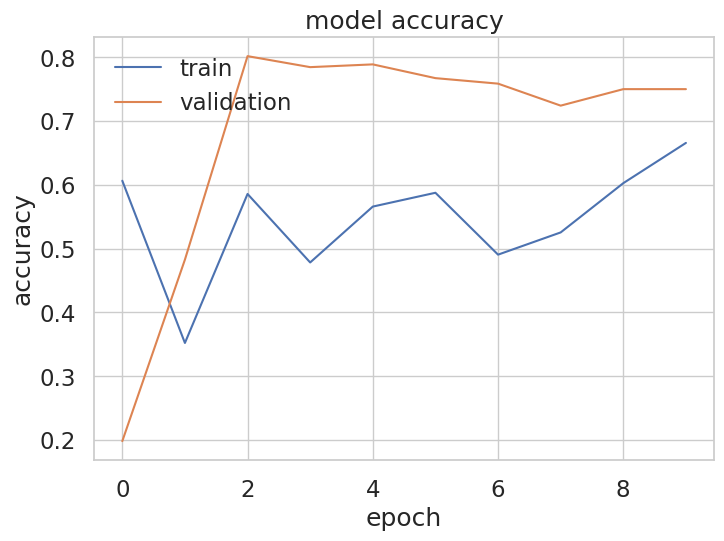

In [81]:
import matplotlib.pyplot as plt
#Accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


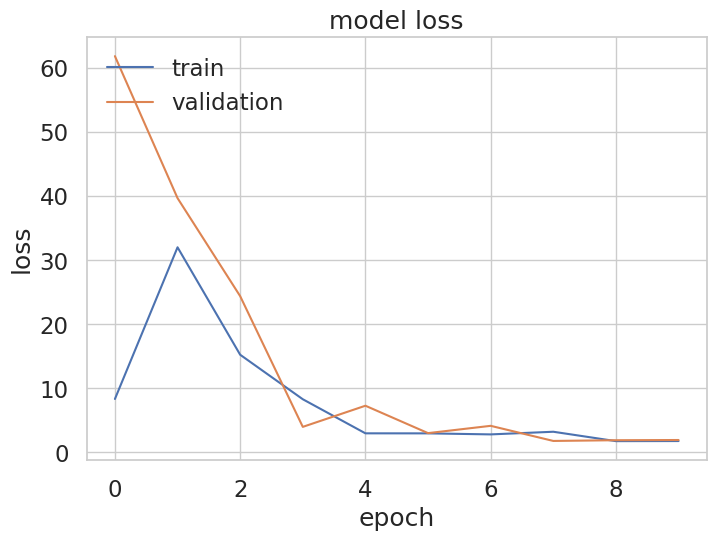

In [82]:
# "Loss"
plt.clf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [83]:
stft_crepe_model.evaluate([test_stft_input, crepe_test_input],y_test_labels)

348/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[33248291.680675287, 0.5]

#### Confusion Matrix

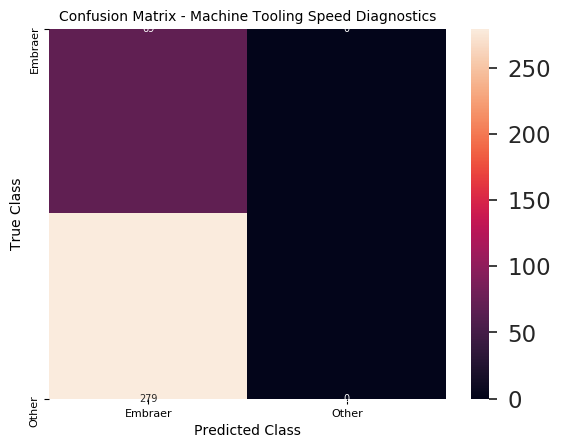

              precision    recall  f1-score   support

         0.0       0.20      1.00      0.33        69
         1.0       0.00      0.00      0.00       279

    accuracy                           0.20       348
   macro avg       0.10      0.50      0.17       348
weighted avg       0.04      0.20      0.07       348



/home/niwilso/.conda/envs/seg/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [84]:
plt.style.use('default')
plt.margins(1)
import matplotlib as mpl
import importlib
import matplotlib
import seaborn as sns

sns.set()
plt.style.use('seaborn')    
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":5})   

preds =np.argmax(stft_crepe_model.predict([test_stft_input, crepe_test_input]), axis=1)
cm = confusion_matrix(y_test.tolist(), preds.tolist())

sns.set(style="whitegrid", font_scale=1.5) 
akws = {"ha": 'center',"va": 'center', 'size':7}
ax = sns.heatmap(cm,  annot=True, fmt='d',annot_kws=akws)

ax.set_title('Confusion Matrix - Machine Tooling Speed Diagnostics', fontsize=10)
ax.xaxis.set_ticklabels(['Embraer', 'Other'], fontsize=8)
ax.yaxis.set_ticklabels(['Embraer', 'Other'], fontsize=8)
ax.set(xlabel='Predicted Class', ylabel='True Class')

    
plt.show()
print(classification_report(y_test.tolist(), preds.tolist()))

In [85]:
cm

array([[ 69,   0],
       [279,   0]])

# The End